In [1]:
%matplotlib inline
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="1"; 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix,explained_variance_score
import time
from datetime import timedelta
import math
import pickle
import pandas
from datapipe import bin_ndarray

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Input, Dense, Flatten, GlobalAveragePooling2D, Conv1D,Conv2D, MaxPooling2D,MaxPooling1D, Dropout, LSTM, TimeDistributed
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
from tensorflow.python.ops import control_flow_ops

orig_while_loop = control_flow_ops.while_loop

def patched_while_loop(*args, **kwargs):
    kwargs.pop("maximum_iterations", None)  # Ignore.
    return orig_while_loop(*args, **kwargs)


control_flow_ops.while_loop = patched_while_loop

In [4]:
def process_dy(dy):
    (length, y, x) = dy.shape
    newdy = np.zeros((length, y-40, x-50), dtype=np.float16)
    for ind, image in enumerate(dy):
        newimg = image[1:-39, 0:-50]
        newdy[ind] = image[1:-39, 0:-50]
    print(newdy[0].shape)
    return bin_dy(newdy)
    # newdyfile = open('./dfy/cropped_AV_2.pkl', 'wb')
#     np.save('./data/cropped_AV_5.npy', newdy)

In [5]:
def bin_dy(dy):
    (length, y, x) = dy.shape
    print(dy.shape)
    newdy = np.zeros((length, int(y/2), int(x/2)), dtype=np.float16)
    for ind, image in enumerate(dy):
        newdy[ind] = bin_ndarray(image, (int(y/2), int(x/2)))
    # newdyfile = open('./dfy/bin_AV_2.pkl', 'wb')
    print(newdy.shape)
    return newdy

In [6]:
# # dataset 1
# df = np.load("r3m1170210s2AVI.npy")
# dy = pickle.load(open('r3m1170210s2.pkl', "rb"))
# # dataset 2
# #(22796,516,388)
# df = np.ndarray.astype(np.load("r4m7170321s1AVI.npy"),dtype=np.float32)
# dy = np.ndarray.astype(pickle.load(open('r4m7170321s1.pkl', "rb")),dtype=np.float32)
# #dataset1
# x_data = df[33:-7280]
# #dataset2
# x_data = df[49:-226]

In [183]:
df_whisk = np.load('./data/whisk_encoded_df2.npy', mmap_mode='r')
print(df_whisk.shape)
# df_whisk_reshape = df_whisk.reshape(52478, 56, 264)
print(df_whisk_reshape.shape)

(52478, 14, 33, 32)
(52478, 56, 264)


In [8]:
#full dataset
dy = np.load('./data/dffAV_2.npy', mmap_mode='r')
(length, y, x) = dy.shape
print(length)

52478


In [ ]:
df = np.load('./data/AV_5_vid.npy', mmap_mode='r')
(lengthdf, ydf, xdf) = df.shape

In [167]:
#10hz data
x_data= (df[::3])
dycropped= (dy[::3])
x_data = process_dy(x_data)
dycropped = process_dy(dycropped)
(lengthdf, ydf, xdf) = x_data.shape
(length, y, x) = dycropped.shape

(706, 872)
(5668, 706, 872)
(5668, 353, 436)
(600, 590)
(5668, 600, 590)
(5668, 300, 295)


In [ ]:
#15hz data
x_data = (df[::2])
dycropped= (dy[::2])

In [185]:
#30hz data
x_data = (df_whisk)
(lengthdf, ydf, xdf, channels) = x_data.shape
dycropped= (dy)

(14, 33, 32)


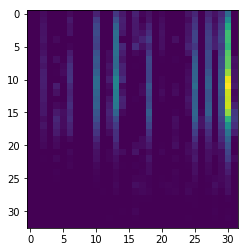

In [189]:
print(x_data[0].shape)
imc = plt.imshow((np.ndarray.astype(df_whisk[0][1], dtype=np.float32)))

In [190]:
num_data = len(x_data)
train_split = 0.7
validation_split = 0.1
num_train = int(train_split*num_data)
num_val = int((num_data - num_train)*validation_split)
num_test = num_data - num_train - num_val
x_train = x_data[0:num_train].reshape(num_train, (xdf*ydf))
x_val = x_data[num_train:(num_train+num_val)].reshape(num_val, (xdf*ydf))
x_test = x_data[(num_train+num_val):].reshape(num_test, (xdf*ydf))
y_train = dycropped[0:num_train].reshape(num_train, (y*x))
y_val = dycropped[num_train:(num_train+num_val)].reshape(num_val, (y*x))
y_test = dycropped[(num_train+num_val):].reshape(num_test, (y*x))

ValueError: cannot reshape array of size 543075456 into shape (36734,462)

In [12]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [13]:
x_train_scaled = np.ndarray.astype(x_train_scaled,np.float16)
x_train_scaled.dtype

dtype('float16')

In [14]:
x_test_scaled = x_scaler.transform(x_test)
x_val_scaled  = x_scaler.transform(x_val)
x_test_scaled = np.ndarray.astype(x_test_scaled,np.float16)
x_val_scaled = np.ndarray.astype(x_val_scaled,np.float16)

In [16]:
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
y_val = y_val.astype(np.float32)

In [17]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled  = y_scaler.transform(y_test)
y_val_scaled   = y_scaler.transform(y_val)

In [18]:
y_train_scaled = np.ndarray.astype(y_train_scaled,np.float16)
y_test_scaled = np.ndarray.astype(y_test_scaled,np.float16)
y_val_scaled = np.ndarray.astype(y_val_scaled,np.float16)

In [19]:
num_x_signals = x_train.shape[1]
print(num_x_signals)
num_y_signals = (x*y)
print(num_y_signals)

14784
88500


In [20]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [21]:
# x_train_scaled = np.ndarray.astype(x_train_scaled, dtype=np.float16)

In [22]:
# y_train_scaled = np.ndarray.astype(y_train_scaled, dtype=np.float16)

In [23]:
# The number of pixels in each dimension of an image.
img_size_x = ydf
img_size_y = xdf

# The images are stored in one-dimensional arrays of this length.
img_size_flat = (xdf*ydf)

# Tuple with height and width of images used to reshape arrays.
img_shape = (ydf,xdf)

# I dont think I have this
# Number of classes, one class for each of 10 digits.
num_classes = y*x

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1


In [24]:
#TODO comeback and make this useful for my data
def plot_images(images, cls_pred=None):
    
    #Create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(images[i].reshape(img_shape).astype(np.float32))
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

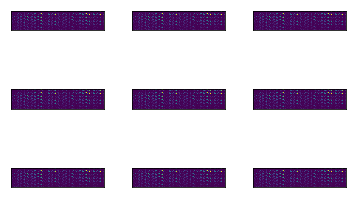

In [25]:
images = x_test[118:127]
plot_images(images=images)

In [65]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, img_size_x, img_size_y,1)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size,sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            idx = np.random.randint(num_train - sequence_length)
            if idx + sequence_length < len(x_train_scaled):
                idx = idx-((idx+sequence_length+1)-len(x_train_scaled))
            for j in range(sequence_length):
                x_batch[i][j] = np.expand_dims(x_train_scaled[idx+j].reshape(img_size_x,img_size_y), axis=3)
                y_batch[i][j] = y_train_scaled[idx+j]

        yield (x_batch, y_batch)

In [104]:
batch_size = 100
sequence_length = 20 #20 frames after stim time

In [105]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [106]:
x_batch, y_batch = next(generator)

/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [107]:
print(x_batch.shape)
print(y_batch.shape)

(100, 20, 56, 264, 1)
(100, 20, 88500)


In [108]:
x_test_scaled = np.ndarray.astype(x_test_scaled.reshape(num_test, img_size_x, img_size_y), np.float16)
x_val_scaled = np.ndarray.astype(x_val_scaled.reshape(num_val, img_size_x, img_size_y),np.float16)


In [109]:
print(len(x_val_scaled))
validation_data = (np.expand_dims(np.expand_dims(x_val_scaled,axis=3), axis=0),
                  np.expand_dims(y_val_scaled, axis=0))
print(validation_data[0].shape)

1574
(1, 1574, 56, 264, 1)


In [171]:
def ConvMLP(input_shape):
    X_input = Input(input_shape)
#     X = TimeDistributed(Conv2D(32, (7, 7), strides = (2, 2), activation='relu', name="Conv_1a", padding="same"))(X_input)
#     X = TimeDistributed(MaxPooling2D((2, 2), name = "Pool_1"))(X)
    
#     X = TimeDistributed(Conv2D(16, (3, 3), name ="Conv_2a", activation='relu', padding = "same"))(X_input)
#     X = TimeDistributed(MaxPooling2D((2, 2), name = "Pool_2"))(X)
    
#     X = TimeDistributed(Conv2D(256,(3,3), name='Conv_3a'))(X)
#     X = TimeDistributed(MaxPooling2D((2, 2), name = "Pool_3"))(X)

    X = TimeDistributed(Flatten())(X_input)
    
    X = LSTM(2, return_sequences=True)(X)
    X = Dropout(0.40)(X)
    X = Dense(num_y_signals, activation='sigmoid')(X)
    
    return Model(X_input,X)

In [172]:
# inp = Input(shape=(batch_size,sequence_length,img_size_x, img_size_y))
# base_model = Sequential()
# base_model.add(Conv2D(100,
#               kernel_size=(4,5),
#               strides=(2,2)))(inp)
# base_model.add(MaxPooling2D(pool_size=(2,2)))
# # base_model.add(Conv2D(150, (5), activation='relu'))
# # base_model.add(GlobalAveragePooling2D())
# base_model.add(Flatten())
# x = TimeDistributed(base_model)(inp)
# x = LSTM(units=5, return_sequences=True)(x)
# x = Dropout(0.15)(x)
# x = (Dense(num_y_signals, activation='sigmoid'))(x)
# model = Model(inp,x)
# # model.add(Dropout(0.15))
# # model.add(Dense(num_y_signals, activation='sigmoid'))

In [173]:
model = ConvMLP((None, img_size_x, img_size_y,1))

In [174]:
optimizer = Adam(lr=1e-3)

In [175]:
model.compile(loss='mse', optimizer=optimizer)

In [176]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, None, 56, 264, 1)  0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, None, 14784)       0         
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 2)           118296    
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 2)           0         
_________________________________________________________________
dense_9 (Dense)              (None, None, 88500)       265500    
Total params: 383,796
Trainable params: 383,796
Non-trainable params: 0
_________________________________________________________________


In [177]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [178]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [179]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [180]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [181]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [182]:
%%time
model.fit_generator(generator=generator,
                    epochs=100,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/100


/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


 99/100 [============================>.] - ETA: 1s - loss: 0.0110

KeyboardInterrupt: 

In [122]:
result = model.evaluate(x=np.expand_dims(np.expand_dims(x_test_scaled[:1000], axis=3),axis=0),
                        y=np.expand_dims(y_test_scaled[:1000],axis=0))

1/1 [==============================] - 3s 3s/step


In [123]:
print(result)

0.03529239445924759


In [ ]:
model.save("DRPlstmCNNds1.h5")

In [129]:
def r2_keras(y_true, y_pred):
    SS_res =  np.sum(np.square(np.subtract(y_true,y_pred))) 
    SS_tot = np.sum(np.square(np.subtract(y_true, np.mean(y_true)))) 
    return ( 1 - SS_res/(SS_tot))

In [138]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled.reshape(num_train,img_size_x,img_size_y)
        y_true = y_train_scaled
    else:
        # Use test-data.
        x = x_test_scaled.reshape(num_test,img_size_x,img_size_y)
        y_true = y_test_scaled 
    
    # End-index for the sequences.
    end_idx = start_idx + length
    # Use the model to predict the output-signals.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    x = np.expand_dims(np.expand_dims(x, axis=3), axis=0)
    y_pred = model.predict(x)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
#     of the original data-set.
#     y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    sum_pred = []
    sum_true = []
    print(y_pred)
    print(y_true)
    # For each output-signal.
    for i in range(len(x[0])):
        sum_pred.append(np.average(y_pred[0][i]))
        sum_true.append(np.average(y_true[i]))
    # Plot and compare the two signals.
    plt.plot(sum_true, label='true')
    plt.plot(sum_pred, label='pred')
    print("r2")
    print(r2_keras(y_true, y_pred[0]))
    print(explained_variance_score(y_true, y_pred[0],multioutput='uniform_average'))
    # Plot grey box for warmup-period.


    # Plot labels etc.
    plt.ylabel("sum")
    plt.legend()
    plt.show()

[[[0.5776095  0.5682336  0.58709055 ... 0.5761595  0.5461073  0.55920535]
  [0.57946724 0.5689439  0.58892405 ... 0.580138   0.5479877  0.5618264 ]
  [0.5797518  0.56905276 0.58920485 ... 0.5807469  0.5482758  0.56222785]
  ...
  [0.57979715 0.5690701  0.5892496  ... 0.5808439  0.54832166 0.5622918 ]
  [0.57979715 0.5690701  0.5892496  ... 0.5808439  0.54832166 0.5622918 ]
  [0.57979715 0.5690701  0.5892496  ... 0.5808439  0.54832166 0.5622918 ]]]
[[0.6665 0.641  0.7188 ... 0.6235 0.6533 0.7104]
 [0.747  0.6904 0.7114 ... 0.633  0.608  0.6353]
 [0.3918 0.4192 0.4326 ... 0.6597 0.6104 0.638 ]
 ...
 [0.5933 0.551  0.5366 ... 0.568  0.4985 0.4246]
 [0.6445 0.6245 0.6216 ... 0.558  0.571  0.5693]
 [0.63   0.597  0.6265 ... 0.5825 0.517  0.4844]]
r2
1.0
-0.0005851723844722166


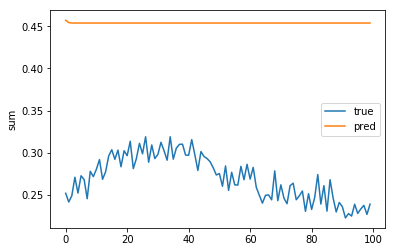

In [139]:
plot_comparison(start_idx=1, length=100, train=False)